# Walmart Sales Data - Interactive Data Visualization & Comprehensive Forecasting

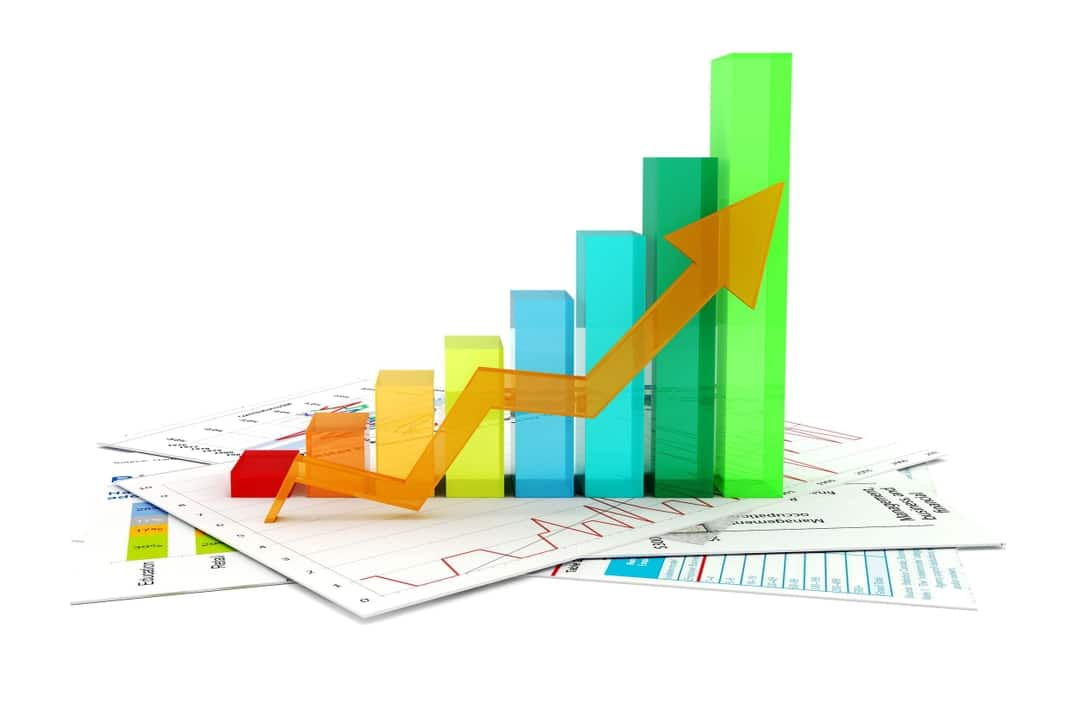

# **Introduction**

Welcome to the Interactive Data Visualization and Comprehensive Forecasting for the 5th Makridakis forecasting competitions (M5). This notebook has been carefully prepared that comprises of both the exploration stage to gather insights from the data as well as the model building and performance evaluation to forecast the Walmart sales. Before we kickstart, let's take a brief background on the competetion:

***Main Question***: Can you estimate, as precisely as possible, the uncertainty distribution of the unit sales of various products sold in the USA by Walmart?

***Objective***: We have to predict daily Walmart sales for future 28 days based on hierarchical sales data and to make uncertainty estimates for these forecasts. The data, covers Walmart's stores in three US States: California, Texas, and Wisconsin. “Hierarchical” means that data can be aggregated on different levels: item level, department level, product category level, and store details level. In addition, we are also given corresponding data (explanatory variables) on prices, promotions, and holidays which can be merged with sales data to draw insights. Note, that we have been warned that most of the time series contain zero values.

The data comprises **3049** individual products from *3 categories* and *7 departments*, sold in *10 stores* in *3 states*. The hierachical aggregation captures the combinations of these factors. For instance, we can create 1 time series for all sales, 3 time series for all sales per state, and so on. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

The training data comes in the shape of 3 separate files:

sales_train.csv: this is our main training data. It has 1 column for each of the 1941 days from 2011-01-29 and 2016-05-22; not including the validation period of 28 days until 2016-06-19. It also includes the IDs for item, department, category, store, and state. The number of rows is 30490 for all combinations of 30490 items and 10 stores.

sell_prices.csv: the store and item IDs together with the sales price of the item as a weekly average.

calendar.csv: dates together with related features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0).

The metrics:

The point forecast submission are being evaluated using the **Root Mean Squared Scaled Error (RMSSE)**, which is derived from the Mean Absolute Scaled Error (MASE) that was designed to be scale invariant and symmetric. In a similar way to the MASE, the RMSSE is scale invariant and symmetric, and measures the prediction error (i.e. forecast - truth) relative to a “naive forecast” that simply assumes that step i = step i-1. In contrast to the MASE, here both prediction error and naive error are scaled to account for the goal of estimating average values in the presence of many zeros.

The uncertainy distributions are being evaluated using the **Weighted Scaled Pinball Loss (WSPL)**. We are asked to provide the 50%, 67%, 95%, and 99% uncertainty intervals together with the forecasted median.

Both metrics are computed for each time series and then averaged accross all time series including weights. The weights are proportional to the sales volume of the item, in dollars, to give more importance to high selling products. Note, that the weights are based on the last 28 days of the training data, and that those dates will be adjusted for the ultimate evaluation data.

In the ***first and second section***, I will provide comprehensive Exploratory Data Analysis on the entire dataset. I shall be using Plotly(mostly) and Matplotlib, so be ready to hover your mouse! :)

In the ***third section***, I will write about the fundamentals of probabilistic forecasting and its role in this competition. I will dissect the hierarchical order of the sales data and how to apply prediction model to grouped time series.

In the ***fourth section***, I will explore the submission file to understanding the required format and perform some EDA to gain insights.

In the ***fifth section***, I will work on model building based on the actual data and understanding gathered from the analysis part and will attempt to forecast sales.

# Table of Contents

[1. Meeting the Data](#section-one)
    
[2. EDA - Interactive Time Series Plots](#section-two)
   - [2.1 Explanatory Variables: Sales Train Validation](#sectiontwo-subone)
   - [2.2 Explanatory Variables: Calendar](#sectiontwo-subtwo) 
   - [2.3 Explanatory Variables: Sell Price](#sectiontwo-subthree)
    
[3. "What is meant by probabilistic forecasting?"...](#prob_forecasting)
   - [What is a grouped time series?](#grouped_ts)
   - [How does the hierarchy look like?](#hierarchy_ts)
   - [How can we generate forecasts for grouped timeseries?](#forecasts_ts)
    
[4. The submission format](#submission)
   - [Intro](#intro)
   - [Prediction intervals and quartiles](#PIs)
   - [Aggregation levels](#sub_aggregation_levels)
   - [Submission EDA](#submission_eda)
   
[5. Facebook's Prophet](#prophet)   

In [1]:
# Importing neccesary packages

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 2000)

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

from datetime import datetime

<a id="section-one"></a>
# Meeting the Data

In [2]:
# Loading the data

calendar= pd.read_csv("calendar.csv")
stv = pd.read_csv("sales_train_validation.csv")
sp = pd.read_csv("sell_prices.csv")

In [3]:
# Checking sales training data

stv.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [4]:
# Checking the shape

stv.shape, calendar.shape, sp.shape

((30490, 1919), (1969, 14), (6841121, 4))

In [5]:
# Checking unique values across categorical variables

cols = ["dept_id", "cat_id", "store_id", "state_id"]

print([stv[i].nunique() for i in cols])
print([stv[i].unique() for i in cols])

[7, 3, 10, 3]
[array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object), array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object), array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object), array(['CA', 'TX', 'WI'], dtype=object)]


***Key Observations***

* This is our training data. It has 1 column (d_* ) for each of the 1913 days starting from 2011-01-29 whcih represents the number of units sold per day, plus a general ID that is a combination of the other IDs plus a flag for validation.
* It also includes the IDs for item, department, category, store, and state. 
* The number of rows are 30490 acorss 3 States ('CA', 'TX', 'WI'), 3 categories ('HOBBIES', 'HOUSEHOLD', 'FOODS'), 3 departments and 10 stores ('CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1','WI_2', 'WI_3')

In [6]:
# Checking calendar data

calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

***Key Observations***

* This is our calendar data. It has 1969 rows and 14 columns.
* It includes features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0)

In [7]:
# Checking the sell price data

sp.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

***Key Observations***

* Here, the sales price of the item is presented as a weekly average across the store and item IDs together. 
* We will combine Calendar and Sell price data with training data to generate insights in the later steps.

<a id="section-two"></a>
# EDA - Interactive Time Series Plots

In [8]:
# Checking missing values first

stv.isnull().sum().sort_values(ascending=True)

id        0
d_1281    0
d_1280    0
d_1279    0
d_1278    0
         ..
d_628     0
d_627     0
d_626     0
d_638     0
d_1913    0
Length: 1919, dtype: int64

No missing values, good news !

In [9]:
# Collecting all days columns (d_*) in a list for data wrangling

d_cols = [col for col in stv.columns if "d_" in col]

In [10]:
# Short helper function for data transformation

def helper_func(df):
    df = df.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1)
    df = df.melt(id_vars="id",var_name='dates',value_name="sales" )
    df["id"] = df["id"].str.replace('_validation', '')
    return df

<a id="subsection-one"></a>
# 2.1 Explanatory Variables: Sales Train Validation

### Random sample
Let's take a random sample and see the distribution - 

In [11]:
# Taking 50 random samples to see the sales distribution
stv_= stv.sample(n=50, random_state=1)

stv_random = helper_func(stv_)

merged = stv_random.merge(calendar, how="left", left_on="dates", right_on="d")

merged_ = pd.DataFrame(merged.groupby("date")["sales"].sum()).reset_index()

fig = px.line(merged_, x="date", y="sales", title='Sales Distribution of random 50 Samples', color_discrete_map= dict(color="red"))
fig.show()

### Aggregate Sales

After peeking at a random 50 samples, we will now do some aggregation to get some decent statistics.

Firstly, we plot the aggregate time series over all items, stores, categories, departments and sales. This is an interactive plot and you can use the usual plotly tools (upper right corner) to zoom, pan, and scale the view.

In [12]:
# Aggregate sales distribution

stv_agg = pd.DataFrame(stv[d_cols].sum()).rename(columns = {0:"sales"})

agg = stv_agg.merge(calendar.set_index("d"), how="left", left_index=True,
             right_index=True, validate="1:1")


fig = px.line(agg, x="date", y="sales")
fig.show()

***Key Observations***:

* The sales has an upward trend. We can observe some yearly seasonality, and a dip at Christmas (zoom-in to see), which is the only day of the year when the stores are closed.

* Further zooming in, we can see strong weekly seasonality (sales going up on weekends, lower in the middle of the week).

### Aggregate Sales across the States

In [13]:
# sales distribution across states

state_agg = stv.groupby("state_id")[d_cols].sum()\
                        .T\
                        .merge(calendar.set_index("d"), how="left", left_index=True,
                         right_index=True, validate="1:1")\
                        .loc[:, ["CA","WI","TX","date"]]

state_agg["date"] = pd.to_datetime(state_agg["date"])

state_agg = state_agg.set_index("date")\
                        .resample("1m").sum()


# Line Plot with plotly.express

fig = px.line(state_agg, title='Sales across States')
fig.show()

***Key Observations***:

* California (CA) sells more items continuously, while Wisconsin (WI) sales were lower till 2013 and then slowly catching up to Texas (TX) and eventually surpassed it in the last months of our training data.

* All 3 states experienced dip in start of each year, and then moving up during the middle of each year and then again going down towards the end of the year. This pattern is consistent across all 3 states.

### Aggregate Sales across the Stores

In [14]:
# sales distribution across stores

store_agg = stv.groupby("store_id")[d_cols].sum()\
                        .T\
                        .merge(calendar.set_index("d"), how="left", left_index=True,
                         right_index=True, validate="1:1")\
                        .loc[:, "CA_1":"date"]

store_agg["date"] = pd.to_datetime(store_agg["date"])

store_agg = store_agg.set_index("date")\
                        .resample("1m").sum()


# Line Plot with plotly.express

fig = px.line(store_agg, title='Sales across Stores')
fig.show()

***Key Observations***:

* Cleary California's stores outperforms other two states stores at mean aggregate sales. CA_3 is the clear winner among all stores, it consistly sells more items. While, CA_4 ranks the lowest.

* CA_2 experienced a high jump in June-2015 till Sep-2015 and then catching up with rest of the stores goig forward. Maybe there were store developments or change in policy (just a thought!) 

### Sales Distributon by Stores across the States

In [15]:
# sales distribution by stores across states

store_agg1 = stv.groupby("store_id")[d_cols].sum()\
                        .T\
                        .merge(calendar.set_index("d"), how="left", left_index=True,
                         right_index=True, validate="1:1")\
                        .loc[:, "CA_1":"WI_3"].reset_index()\
                        .melt(id_vars = "index", var_name= "store_id", value_name="sales")

# Box Plot with plotly.express

fig = px.box(store_agg1, x="store_id", y="sales", color="store_id", points="all", title="Sales Distribution by Stores across States")

fig.show()

***Key Observations***:

* The above plot compares the sales distribution for each stores across states. The stores in California seem to have the highest variance in sales, which might indicate that some places in California grow significantly faster than others, i.e. there is income disparity. 

* On the other hand, the Wisconsin and Texas sales seem to be quite consistent among themselves, without much variance. This indicates that development might be more uniform in these states.

* The variance is lowest in Wisconsin and highest in California.

* Zero sales corrosponds to Christmas when stores are closed. Also, there are a few days where the daily sales is higher than the average sales among few stores (TX_2/3, WI_1/2).

### Average Sales across Stores

In [16]:
### Average Sales across Stores

store_agg1_ = pd.DataFrame(store_agg1.groupby("store_id")["sales"].mean()).reset_index()

# Bar Plot with plotly.express

fig = px.bar(store_agg1_, y="sales", x="store_id", color="store_id", title="Mean sales across Stores", text="sales")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

***Key Observations***

* California stores have the highest variance and mean sales among all the stores. The store CA_3 has maximum sales while the store CA_4 has minimum sales, clearly indicate income disparity.
 
* Texas stores ranks second in the overall mean sales and showing similar mean Sales across its 3 stores, TX_2 being the highest and TX_1 being the lowest. Clearly, no disparity.
 
* Wisconsin's stores are no far off than Texas's, WI_2 and W1_3 have same mean Sales, W1_1 lowest among them.

### Sales Distribution across Category and Departments

In [17]:
### Sales Distribution across Category and Departments

cat_agg = stv.groupby(["cat_id", "dept_id"])[d_cols].sum()
cat_agg = pd.DataFrame(cat_agg.sum(axis=1)).reset_index().rename({0:"sales"}, axis=1)

# Subplots and Pie charts with plotly

fig = make_subplots(rows=1, cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(values=cat_agg['sales'], labels=cat_agg['cat_id']), 1,1)
fig.add_trace(go.Pie(values=cat_agg['sales'], labels=cat_agg['dept_id']), 1,2)

# updating traces and layout

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Percentage Sales Distribution across Category and Departments",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Category', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Department', x=0.82, y=0.5, font_size=20, showarrow=False)])

fig.show()

### Total Sales across Departments

In [18]:
# Bar Plot with plotly.express

fig = px.bar(cat_agg, y='sales', x='dept_id', text='sales', title="Total Sales across Departments", color="dept_id")

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

***Key Observations:***

* “Foods” are the most common category (~69%), followed by “Household” (22%) and then “Hobbies” (9.32%). Total Sales of Foods_3 (32M) is close to rest of the department's sales combined.
* "Food_3" contributes 50% of Foods overall sales. It is also the highest sales contributer amongst all departments.
* "Household_1" and "Hobbies_1" are the highest sales contributer within Household and Hobbies category respectively.

### Total Sales in States across Departments

In [19]:
### Total Sales in States across Departments

state_dept = stv.groupby(["state_id","dept_id"])[d_cols].sum()
state_dept = state_dept.sum(axis=1)
state_dept = pd.DataFrame(state_dept).reset_index().rename({0:"sales"}, axis=1)

# Bar Plot with plotly.express

fig = px.bar(state_dept, x="state_id", y="sales", color="dept_id", text="sales", title="Sales per Department across States")

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

***Key Observations:***

* “FOODS_3” is clearly driving the majority of “FOODS” category sales. 
* Similarly, “HOUSEHOLD_1” is clearly outselling “HOUSEHOLD_2”. “HOBBIES_1” is on a higher total sales level than “HOBBIES_2”.

 <a id="subsection-two"></a>
 # 2.2 Explanatory Variables: Calendar
 
 ## 2.2.1 Calendar : Year/Month/Weekdays Insights
 
Let's so some data wrangling to produce sales distribution insights across year, month and weekdays:

### Year-wise Insights

In [20]:
# yearly sales distribution

stv1 = pd.DataFrame(stv[d_cols].T.sum(axis=1))\
                                        .rename({0:"sales"}, axis=1)\
                                        .merge(calendar.set_index("d"),how="left", left_index=True,
                                         right_index=True, validate="1:1")

stv1 = stv1.groupby(["year","month","weekday"])["sales"].sum()
stv1 = pd.DataFrame(stv1)

# Bar Plot with plotly.express

fig = px.bar(stv1.reset_index(), x="year", y="sales", color="year", text="sales", title="Year-wise Contribution across each Month")

fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

### Month-wise Insights

In [21]:
# monthly sales distribution

stv1 = pd.DataFrame(stv[d_cols].T.sum(axis=1))\
                                        .rename({0:"sales"}, axis=1)\
                                        .merge(calendar.set_index("d"),how="left", left_index=True,
                                         right_index=True, validate="1:1")

stv1 = stv1.groupby(["year","month","weekday"])["sales"].sum()
stv1 = pd.DataFrame(stv1)

# Bar Plot with plotly.express

fig = px.bar(stv1.reset_index(), x="month", y="sales", color="weekday", text="sales", title="Monthy Sales bifurcated by weekdays")

fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

### Weekdays Insights

In [22]:
# weekday sales distribution

_stv1 = stv1.reset_index()

# Pie charts with plotly

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen', "red", "cyan", "blue"] #setting colors for each weekday

fig = go.Figure(data=[go.Pie(labels=_stv1["weekday"],
                             values=_stv1["sales"], pull=[0, 0.2, 0.1, 0, 0, 0, 0])])

fig.update_traces(hoverinfo='label+percent+name', textinfo='value', textfont_size=15,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Weekdays Contribution",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Weekday', x=0.5, y=0.5, font_size=20, showarrow=False)])

fig.show()

***Key Observations:***

* Sales has an increasing trend over the years, which is good for Walmart.
* Sales is the highest in March and lowest in January and May. The months of Nov and Dec show clear dips, while the summer months May, Jun, and Jul suggest a milder secondary dip.
* Weekends (Sunday and Saturday) are the highest sales contributer, followed by Friday and Monday, seems like they get benefit from the weekend!
* Wednesday has lowest sales which is understood, middle of the week!

### Let's bring everything together!

In [23]:
# Bar Plot with plotly.express

fig = px.bar(stv1.reset_index(), x="month", y="sales", color="weekday", 
            facet_row="year", facet_col="weekday", text="sales", title="Sales across each Month on Weekdays across Years")

fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

## 2.2.2 Calendar : Events Insights

* There are other features which deals with events and food stamps.
* There are two types of events in the dataset, Event_1 and Event_2. We will analyze each one of them.
* Also, there are 3 SNAP columns, the acronym SNAP stands for [Supplemental Nutrition Assistance Program](http://www.benefits.gov/benefit/361). 

***What is this program?***

*The Supplemental Nutrition Assistance Program (SNAP) is the largest federal nutrition assistance program. SNAP provides benefits to eligible low-income individuals and families via an Electronic Benefits Transfer card. This card can be used like a debit card to purchase eligible food in authorized retail food stores.*


###  Event_1 Analysis

<AxesSubplot:title={'center':'Events Type (%)'}, ylabel='Days with Events (%)'>

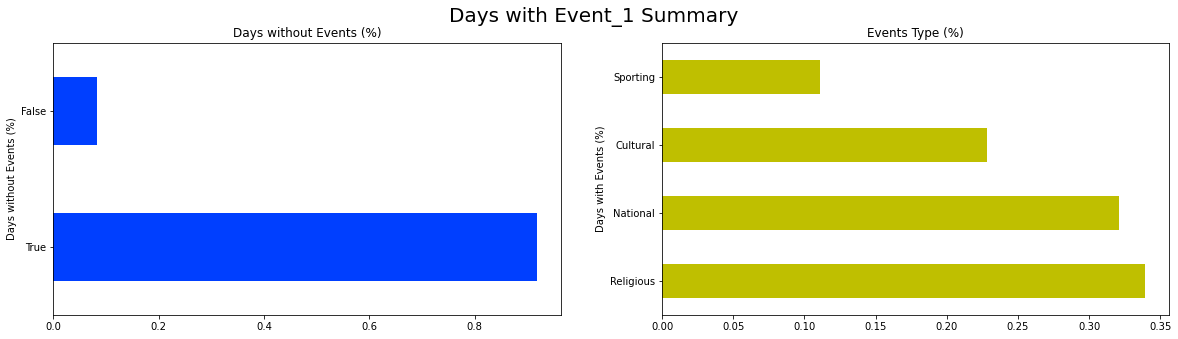

In [24]:
# Bar charts with matplotlib

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("Days with Event_1 Summary", fontsize=20)

calendar["event_name_1"].isnull().value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days without Events (%)", ax=ax1, title="Days without Events (%)")

calendar["event_type_1"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days with Events (%)", ax=ax2, color='y', title="Events Type (%)")

In [25]:
# considering only event days for analysis 

calendar_e1 = calendar[~calendar["event_name_1"].isnull()]

event1 = pd.DataFrame(calendar_e1[["event_type_1", "event_name_1"]].value_counts())\
                                                                   .reset_index()\
                                                                   .rename({0:"events"}, axis=1)

# subplots and pie charts with plotly

fig = make_subplots(rows=1, cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(values=event1['events'], labels=event1['event_type_1']), 1,1)

fig1 = px.sunburst(event1, path=['event_type_1', 'event_name_1'], values='events',
                  color='events',hover_data=['events'], color_continuous_scale='RdBu', title = "Events distribution per Event Types")

fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Events Distribution by Event Type",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Event Type', x=0.18, y=0.5, font_size=20, showarrow=False)])

fig.show()
print(event1)
fig1.show()

   event_type_1         event_name_1  events
0      Sporting            SuperBowl       6
1     Religious       Ramadan starts       6
2     Religious            LentStart       6
3      National        PresidentsDay       6
4     Religious            LentWeek2       6
5      National          MemorialDay       6
6     Religious           Pesach End       6
7     Religious            Purim End       6
8      Cultural        ValentinesDay       6
9      Cultural        StPatricksDay       6
10     Cultural         Mother's day       6
11     Sporting         NBAFinalsEnd       6
12     Sporting       NBAFinalsStart       6
13    Religious          Eid al-Fitr       5
14    Religious       OrthodoxEaster       5
15    Religious    OrthodoxChristmas       5
16    Religious            EidAlAdha       5
17     Cultural        Cinco De Mayo       5
18    Religious         Chanukah End       5
19     National          VeteransDay       5
20     Cultural               Easter       5
21     Nat

***Key Observations:***

* In our calendar data, about 8% of days have a special event. Of these events, about 1/3 are Religious and National Holidays. The remaining third is again split into 2/3 Cultural and 1/3 Sporting events.

* Second pie charts depicts the event's count by event type. Father's day occured only 4 times, while many of them have a count of 5 & 6.

###  Event_2 Analysis

<AxesSubplot:title={'center':'Events Names (%)'}, ylabel='Event Name'>

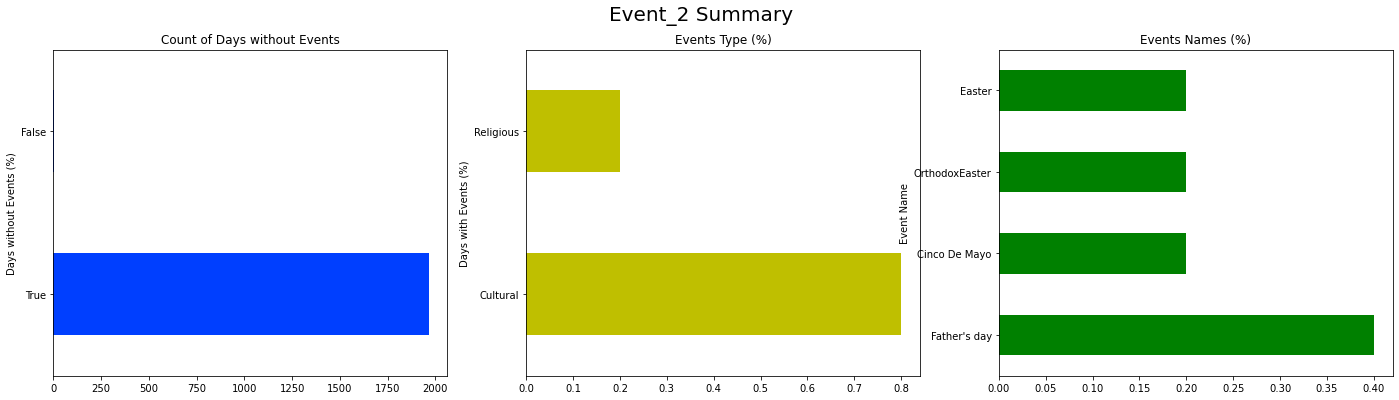

In [26]:
# Bar charts with matplotlib

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,6))
fig.suptitle("Event_2 Summary", fontsize=20)

calendar["event_name_2"].isnull().value_counts()\
                                                .plot(kind="barh", xlabel="Days without Events (%)", ax=ax1, title="Count of Days without Events")

calendar["event_type_2"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days with Events (%)", ax=ax2, color='y', title="Events Type (%)")

calendar["event_name_2"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Event Name", ax=ax3, color='g', title="Events Names (%)")

***Key Observations:***

* In our calendar data, about 0.002% of days (5 days in total) have a special event. Of these events, about 80% are Cultural and rest 20% are Religious. Father's day has the highest percentage (40%), rest of the events have equal percentages (20%).

## 2.2.3 SNAP Days Analysis

<AxesSubplot:title={'center':'% of Days with SNAP purchases'}>

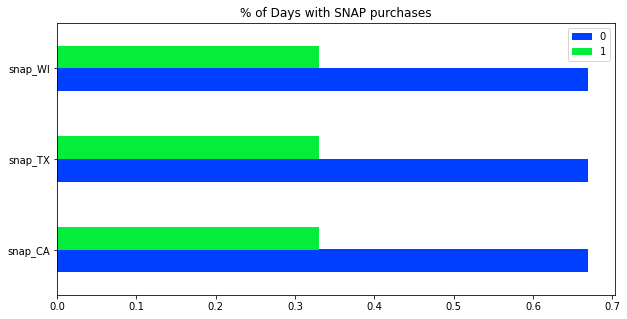

In [27]:
#snap days purchases

snap = ['snap_CA',"snap_TX","snap_WI"]

pd.DataFrame([calendar[s].value_counts(normalize=True) for s in snap])\
                                    .plot(kind="barh", figsize=(10,5), title="% of Days with SNAP purchases")

***Key Observations:***

Looking at the percentage of days where purchases with SNAP food stamps are allowed in Walmart stores, we find that it is the exact same for each of the 3 states: 650 days or 33%. This is noteworthy.

 <a id="subsection-three"></a>
 # 2.3 Explanatory Variables: Sell Price
 
Let's do some data manipulation to extract some of the features from existing features:

In [28]:
# Extracting categorty, department and state IDs from dataset

sp["cat_id"] = sp["item_id"].apply(lambda x : str.rstrip(x[:-6]))
sp["dept_id"] = sp["item_id"].apply(lambda x : x[-5])
sp["state_id"] = sp["store_id"].apply(lambda x : x[:-2])

### Density Plot

In [29]:
# Plotting sell price density plots

plt.figure(figsize=(25,6))

p1 = sns.kdeplot(sp[sp['cat_id']=='HOBBIES']['sell_price'], shade=True, color="b")

p2 = sns.kdeplot(sp[sp['cat_id']=='FOODS']['sell_price'], shade=True, color="r")

p3 = sns.kdeplot(sp[sp['cat_id']=='HOUSEHOLD']['sell_price'], shade=True, color="g")

plt.legend(labels=['HOBBIES','FOODS',"HOUSEHOLD"])
plt.xscale("log")
plt.xlabel("Log of Prices")
plt.ylabel("Density")
plt.title("Density plot of log of prices accross Categories")

Text(0.5, 1.0, 'Density plot of log of prices accross Categories')

***Key Observations:***

* Most of the prices for food products lie between 1 dollars and 10 dollars. As we can see the high peak between 10^0 and 10^1. 
* Hobbies show a pretty wide range of prices.
* Households are costlier than Food.

### Selling Price Distribution across Categories, States and Departments

In [30]:
# Plotting Selling Price Distribution across Categories, States and Departments

df = sp.groupby(["cat_id", "state_id","dept_id"])["sell_price"].agg(["mean","sum"])
df.reset_index(inplace=True)

# plots with plotly

fig = px.sunburst(df, path=['cat_id', 'state_id',"dept_id"], values='sum',
                  color='mean',hover_data=['mean'], color_continuous_scale='RdBu', title = "Selling Price Distribution across Categories, States and Departments")

fig1 = px.treemap(df, path=['cat_id', 'state_id',"dept_id"], values='sum',
                  color='sum',hover_data=['sum'])

print(df)
fig.show()
fig1.show()

       cat_id state_id dept_id      mean           sum
0       FOODS       CA       1  3.291648  6.823291e+05
1       FOODS       CA       2  4.115658  1.285102e+06
2       FOODS       CA       3  2.851724  2.092866e+06
3       FOODS       TX       1  3.359969  5.345878e+05
4       FOODS       TX       2  3.994342  1.074606e+06
5       FOODS       TX       3  2.834728  1.586946e+06
6       FOODS       WI       1  3.499258  5.487467e+05
7       FOODS       WI       2  4.142846  1.002676e+06
8       FOODS       WI       3  2.836702  1.536222e+06
9     HOBBIES       CA       1  6.251518  2.385342e+06
10    HOBBIES       CA       2  2.688043  3.441555e+05
11    HOBBIES       TX       1  6.165732  1.784967e+06
12    HOBBIES       TX       2  2.689812  2.622217e+05
13    HOBBIES       WI       1  6.251939  1.808542e+06
14    HOBBIES       WI       2  2.682205  2.629876e+05
15  HOUSEHOLD       CA       1  5.063647  2.331470e+06
16  HOUSEHOLD       CA       2  5.857440  2.842979e+06
17  HOUSEH

***Key Observations:***

* HOUSEHOLD has the highest average sales, followed by HOBBIES and FOODS.
* Department 1 in HOBBIES has the highest average Sales, while department 3 in FOODS has the lowest average sales.
* Department 2 in HOUSEHOLD has the highest Sales across all 3 states.
* Department 2 in HOBBIES has the lowest Sales across all 3 states.
* Department 3 in FOODS has the lowest Sales across all 3 states.

### Event vs Non Event Analysis

In [31]:
# Median Sales during event vs non-event days

df2 = stv.groupby("cat_id")[d_cols].sum()\
                             .T\
                             .merge(calendar[["date","d","event_type_1"]].set_index("d"), how="left", left_index=True,
                              right_index=True, validate="1:1")

df2["event_type_1"] = df2.event_type_1.map({'Sporting':"Event", 'Cultural':"Event", 'National':"Event", 'Religious':"Event"})
df2.event_type_1.fillna("No Event", inplace=True)

df2_ = df2.melt(id_vars=["date","event_type_1"], var_name='category',value_name="sales")
df2_ = df2_.groupby(["category","event_type_1"])["sales"].median().reset_index()

fig = px.bar(df2_, x="category", y="sales", color="event_type_1", title="Median Sales on Event vs Non-Event Days", text="sales")
fig.show()

In [32]:
# Event vs Non event Sales distribution

fig1 = px.line(df2, x="date", y="FOODS", color="event_type_1", title = "Event vs Non-Event Sales distribution across Categories")

fig2 = px.line(df2, x="date", y="HOBBIES", color="event_type_1")

fig3 = px.line(df2, x="date", y="HOUSEHOLD", color="event_type_1")

fig1.show()
fig2.show()
fig3.show()

***Key Observations***

For FOODS the lines of event vs non-event sales are pretty similar, while for HOBBIES the red event line is consistently below the non-events and for HOUSEHOLD the same is true after 2013.

The FOODS sales are pretty comparable between events and non-events, while the event sales for HOUSEHOLD and especially HOBBIES are notably below the non-event level.

### Category-wise Sales Contribution on Event Days

In [33]:
# Category-wise Sales Contribution on Event Days

df3 = stv.groupby("cat_id")[d_cols].sum()\
                             .T\
                             .merge(calendar[["date","d","event_type_1"]].set_index("d"), how="left", left_index=True,
                              right_index=True, validate="1:1")

df3_ = df3[~df3["event_type_1"].isnull()]\
                            .groupby("event_type_1")[["FOODS", "HOBBIES", "HOUSEHOLD"]].sum()\
                            .reset_index()

# Define color sets of paintings
food_colors = ['rgb(56, 75, 126)', 'rgb(18, 36, 37)', 'rgb(34, 53, 101)',
                 'rgb(36, 55, 57)']
hobb_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)',
                 'rgb(175, 49, 35)']
house_colors =  ['rgb(146, 123, 21)', 'rgb(177, 180, 34)', 'rgb(206, 206, 40)',
                'rgb(175, 51, 21)']


fig = make_subplots(1, 3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['FOODS', 'HOBBIES', "HOUSEHOLD"])

fig.add_trace(go.Pie(labels=df3_["event_type_1"], values=df3_["FOODS"], textinfo='label+percent', marker_colors=food_colors), 1, 1)
fig.add_trace(go.Pie(labels=df3_["event_type_1"], values=df3_["HOBBIES"], textinfo='label+percent', marker_colors=hobb_colors), 1, 2)
fig.add_trace(go.Pie(labels=df3_["event_type_1"], values=df3_["HOUSEHOLD"], textinfo='label+percent', marker_colors=house_colors), 1, 3)


fig.update_layout(title_text='Category-wise Sales Contribution on Event Days')
fig.show()

***Key Observations***

* National and Religious events contributes for the maximum sales across all 3 categories.
* Sporting events has lower contribution towards the net sales.

# "What is meant by probabilistic forecasting?"... <a class="anchor" id="prob_forecasting"></a>

When I read about this competition this was one of the first questions that came into my mind. I know a few probabilistic models and methods and I have done some time series analysis before but I haven't directly got in touch with probabilistic timeseries analysis so far. The M5 competition is a good way to close this gap and to learn something new. To start I like to follow a question driven approach...

## What is a grouped time series? <a class="anchor" id="grouped_ts"></a>

* Reading the competiton guideline we can find out that we have to deal with grouped time series of unit sales data. 
* They show a hierarchy of different aggregation levels that are weighted equally in the loss functions. 
* When working with grouped time series it's common to compute forecasts only for disaggregated time series and to add them up the same way the aggregation is performed for all remaining time series. 
* In Chapter 10 of [Forecasting - Principles and Practice](https://otexts.com/fpp2/hierarchical.html) we can find even more information about how to do this "forecasting aggregation".

## How does the hierarchy look like? <a class="anchor" id="hierarchy_ts"></a>

In the competition guideline we can find that the hierarchy consits of 12 levels. Let's try to reconstruct some of them:

1. The top is given by the unit sales of all products, aggregated for all stores/states. 
2. Unit sales of all products, aggregated for each state.
3. Unit sales of all products, aggregated for each store.
4. Unit sales of all products, aggregated for each category.
5. Unit sales of all products, aggregated for each department.

...

In [34]:
series_cols = stv.columns[stv.columns.str.contains("d_")].values
level_cols = stv.columns[stv.columns.str.contains("d_")==False].values

In [35]:
stv.head(1)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   

   d_97  d_98  d_99  d_100  d_101  d_102  d_103  d_104  d_105  d_106  d_107  \
0     0     0     0      0      0      0      0      0      0      0      0   

   d_108  d_109  d_110  d_111  d_112  d_113  d_114  d_115  d_116  d_117  \
0      0      0      0      0      0      0      0      0      0      0   

   d_118  d_119  d_120  d_121  d_122  d_123  d_124  d_125  d_126  d_127  \
0      0      0      0      0      0      0      0      0      0      0   

   d_128  d_129  d_130  d_131  d_132  d_133  d_134  d_135  d_136  d_137  \
0      0      0      0      0      0      0      0      0      0      0   

   d_138  d_139  d_140  d_141  d_142  d_143  d_144  d_145  d_146  d_147  \
0      0      0      0      0      0      0      0      0      0      0   

   d_148  d_149  d_150  d_151  d_152  d_153  d_154  d_155  d_156  d_157  \
0      0      0      0      0      0      0      0      0      0      0   

   d_158  d_159  d_160  d_161  d_162  d_163  d_164  d_165  d_166  d_167  \
0      0      0      0      0      0      0      0      0      0      0   

   d_168  d_169  d_170  d_171  d_172  d_173  d_174  d_175  d_176  d_177  \
0      0      0      0      0      0      0      0      0      0      0   

   d_178  d_179  d_180  d_181  d_182  d_183  d_184  d_185  d_186  d_187  \
0      0      0      0      0      0      0      0      0      0      0   

   d_188  d_189  d_190  d_191  d_192  d_193  d_194  d_195  d_196  d_197  \
0      0      0      0      0      0      0      0      0      0      0   

   d_198  d_199  d_200  d_201  d_202  d_203  d_204  d_205  d_206  d_207  \
0      0      0      0      0      0      0      0      0      0      0   

   d_208  d_209  d_210  d_211  d_212  d_213  d_214  d_215  d_216  d_217  \
0      0      0      0      0      0      0      0      0      0      0   

   d_218  d_219  d_220  d_221  d_222  d_223  d_224  d_225  d_226  d_227  \
0      0      0      0      0      0      0      0      0      0      0   

   d_228  d_229  d_230  d_231  d_232  d_233  d_234  d_235  d_236  d_237  \
0      0      0      0      0      0      0      0      0      0      0   

   d_238  d_239  d_240  d_241  d_242  d_243  d_244  d_245  d_246  d_247  \
0      0      0      0      0      0      0      0      0      0      0   

   d_248  d_249  d_250  d_251  d_252  d_253  d_254  d_255  d_256  d_257  \
0      0      0      0      0      0      0      0      0      0      0   

   d_258  d_259  d_260  d_261  d_262  d_263  d_264  d_265  d_266  d_267  \
0      0      0      0      0      0      0      0      0      0      0   

   d_268  d_269  d_270  d_271  d_272  d_273  d_274  d_

In [36]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
stv[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
stv.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
stv.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
stv.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
stv.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

### Insights

* It has become much clearer how these levels are aggregated by performing groupby- and summing up the sales.
* We can already observe nice periodic patterns.

## How can we generate forecasts for grouped timeseries? <a class="anchor" id="forecasts_ts"></a>

* Our training data consists of 30490 timeseries. They belong to the bottom-level 12: Unit sales of product x, aggregated for each store.
* A simple method to generate forecasts for all levels is to focus only on the bottom level. All of its predictions are then summed up to create the forecasts of all levels up to the top. This is called the bottom-up approach. 
* As you can see [here](https://otexts.com/fpp2/bottom-up.html), there are many more approaches one could use, for example top-down or middle-out. 

# The submission format <a class="anchor" id="submission"></a>

## Intro <a class="anchor" id="intro"></a>

* We have 28 F-columns as we are predicting daily sales for the next 28 days. 
* We are asked to make uncertainty estimates for these days.

In [37]:
submission = pd.read_csv("sample_submission.csv")
submission.head(10)

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  F11  \
0  Total_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
1     CA_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
2     TX_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
3     WI_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
4   CA_1_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
5   CA_2_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
6   CA_3_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
7   CA_4_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
8   TX_1_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   
9   TX_2_X_0.005_validation   0   0   0   0   0   0   0   0   0    0    0   

   F12  F13  F14  F15  F16  F17  F18  F19  F20  F21  F22  F23  F24  F25  F26  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
5    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
6    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
7    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
8    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
9    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   F27  F28  
0    0    0  
1    0    0  
2    0    0  
3    0    0  
4    0    0  
5    0    0  
6    0    0  
7    0    0  
8    0    0  
9    0    0

In [38]:
submission.shape

(771120, 29)

* In the first submission row we are asked to make precitions for the top level 1 (unit sales of all products, aggregated for all stores/states)
* The next 3 rows represent level 2.
* Followed by level 3. 
* This may goes on and on until the bottom level 12 is reached? Probably not as there seem to be only 3 combinations of ids.
* Some rows contain aggregations at different levels. An X indicates the absence of an second aggregration level.
* The prediction interval can be validation (related to the public leaderboard) or evaluation (related to the private leaderboard).

## Prediction intervals and quartiles <a class="anchor" id="PIs"></a>

Reading in the competition guideline, we can find that we are asked to make predictions for the median and four prediction intervals (PI): 50%, 67%, 95% and 99%. They belong to the following quartiles:

* 99% PI - $u_{1} = 0.005$ and $u_{9} = 0.995$
* 95% PI - $u_{2} = 0.025$ and $u_{8} = 0.975$
* 67% PI - $u_{3} = 0.165$ and $u_{7} = 0.835$
* 50% PI - $u_{4} = 0.25$ and $u_{6} = 0.75$
* median - $u_{5} = 0.5$

## Aggregation levels <a class="anchor" id="sub_aggregation_levels"></a>

In [39]:
np.random.choice(submission.id.values, replace=False, size=15)

array(['HOUSEHOLD_2_137_CA_3_0.005_evaluation',
       'TX_FOODS_1_169_0.025_evaluation',
       'FOODS_2_029_WI_3_0.005_validation',
       'HOBBIES_2_017_WI_1_0.005_evaluation',
       'HOUSEHOLD_1_423_CA_1_0.500_validation',
       'HOUSEHOLD_2_361_WI_3_0.005_validation',
       'HOBBIES_1_079_CA_4_0.500_evaluation',
       'FOODS_2_171_TX_1_0.995_validation',
       'WI_HOUSEHOLD_2_148_0.835_evaluation',
       'FOODS_3_295_TX_2_0.250_evaluation',
       'HOUSEHOLD_1_247_WI_2_0.500_evaluation',
       'FOODS_3_473_CA_3_0.025_evaluation',
       'CA_FOODS_3_113_0.975_validation',
       'WI_FOODS_3_132_0.005_validation',
       'TX_HOUSEHOLD_2_215_0.005_evaluation'], dtype=object)

Browsing through the submission ids, we can see that we are given values of $u_{i}$ and information about the aggregation type like:

* the state id
* the department id
* the item id
* the store id

It's a bit confusing that missing states are not represented by X. This makes splitting the id for EDA a bit more complicated. Furthermore there is no clear separator. The $ \_ $ sign is also present in the department id. **It seems that one asked aggregation always consists of 3 ids. In cases of counts smaller than 3, we can observe X as placeholder.**  

## Submission EDA <a class="anchor" id="submission_eda"></a> 

In [40]:
def find_quartil(l):
    
    if "0.005" in l:
        return 0.005
    elif "0.025" in l:
        return 0.025
    elif "0.165" in l:
        return 0.165
    elif "0.25" in l:
        return 0.25
    elif "0.5" in l:
        return 0.5
    elif "0.75" in l:
        return 0.75
    elif "0.835" in l:
        return 0.835
    elif "0.975" in l:
        return 0.975
    elif "0.995" in l:
        return 0.995
    else:
        return 0
    
def find_state(l):
    if "CA" in l:
        return "CA"
    elif "TX" in l:
        return "TX"
    elif "WI" in l:
        return "WI"
    else:
        return "Unknown"
    
def find_category(l):
    if "FOODS" in l:
        return "foods"
    elif "HOBBIES" in l:
        return "hobbies"
    elif "HOUSEHOLD" in l:
        return "household"
    else:
        return "Unknown"

In [41]:
submission_eda = pd.DataFrame(submission.id, columns=["id"])
submission_eda.loc[:, "lb_type"] = np.where(submission.id.str.contains("validation"), "validation", "evaluation")
submission_eda.loc[:, "u"] = submission.id.apply(lambda l: find_quartil(l))
submission_eda.loc[:, "state"] = submission.id.apply(lambda l: find_state(l))
submission_eda.loc[:, "category"] = submission.id.apply(lambda l: find_category(l))

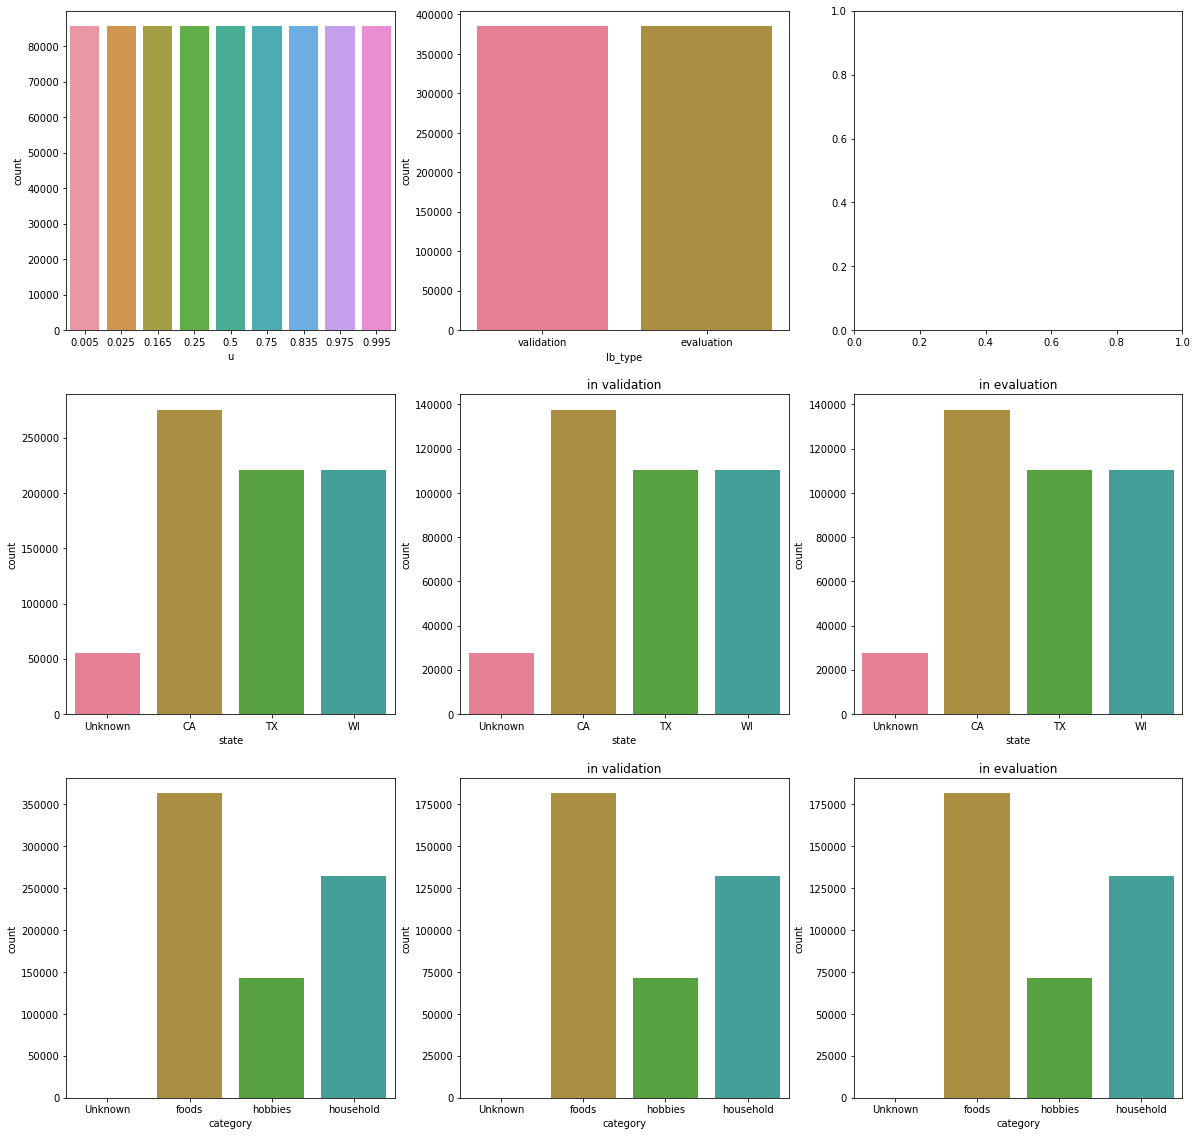

In [42]:
sns.set_palette("husl")

fig, ax = plt.subplots(3,3,figsize=(20,20))
sns.countplot(submission_eda.u, ax=ax[0,0]);
sns.countplot(submission_eda.lb_type, ax=ax[0,1]);
sns.countplot(submission_eda.state, ax=ax[1,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].state, ax=ax[1,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].state, ax=ax[1,2]);
sns.countplot(submission_eda.category, ax=ax[2,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].category, ax=ax[2,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].category, ax=ax[2,2]);
for n in range(1,3):
    ax[n,2].set_title("in evaluation")
    ax[n,1].set_title("in validation")

### Insights

* Each quartile u has exactily $2*42840 = 85680$ requests. The total number of all 12 level timeseries is 42840.
* We have the same number of validation and evaluation requests and this explains the factor 2.
* It seems that really all 12 aggregation levels are represented in the submission id.

# Facebook's Prophet <a class="anchor" id="prophet"></a>


## Model description

[Prophet](https://facebook.github.io/prophet/) is a decomposable time series model with 3 main model components and one error term:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$

* trend g(t) - non-periodic changes of the value
* seasonality s(t) - periodic changes (e.g. weekly and yearly) 
* holidays h(t) - effect of holidays (e.g. irregular patterns over one or more days)
* $\epsilon_{t}$ - error term that describes any idiosyncratic changes (assumed to be normally distributed)


## Uncertainty estimates

By default it returns uncertainty intervals of the predicted value $y_{hat}$ consisting of three different sources:
* uncertainty in the trend,
* uncertainty in the seasonality estimates,
* additional observation noise

To compute the uncertainty in the trend it is assumed that the average frequency and magnitude of trend changes will be the same in the future as observed in the history. This trend changes are projected forward into the future and by computing their distribution uncertainty intervals are obtained. **By default Prophet only returns uncertainty in the trend and observation noise!**

## Example - Total unit sales prediction

Let's sum up all unit sales given in our training data to obtain the top level time series of total unit sales of all stores and states:

In [43]:
timeseries = stv[series_cols].sum().values
len(timeseries)

1913

As we are asked to predict a time window of 28 days, the easiest way to go now is to use the last 28 days for validation: 

In [44]:
train_timeseries = timeseries[0:-28]
eval_timeseries = timeseries[-28::]
print(len(train_timeseries), len(eval_timeseries))
days = np.arange(1, len(series_cols)+1)

1885 28


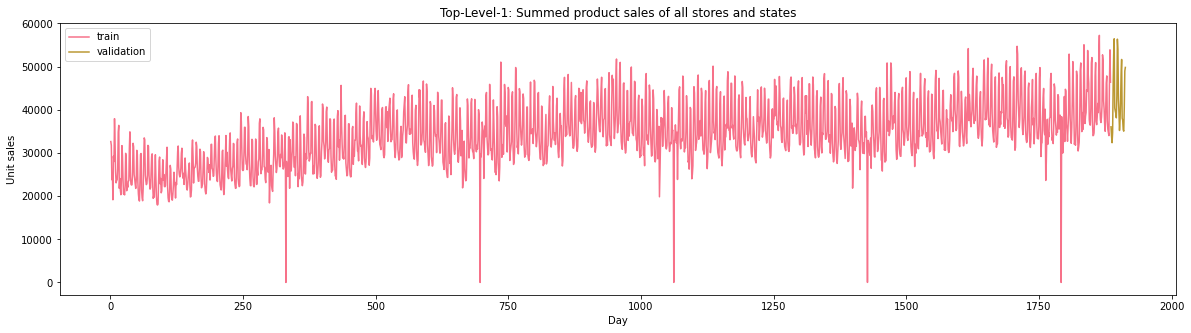

In [45]:
plt.figure(figsize=(20,5))
plt.plot(days[0:-28], train_timeseries, label="train")
plt.plot(days[-28::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

As far as I currently know Prophet likes to have the dates that we can find in our calendar dataframe:

In [46]:
dates = calendar.iloc[0:len(timeseries)].date.values
df = pd.DataFrame(dates, columns=["ds"])
df.loc[:, "y"] = timeseries
df.head()

ds      y
0  2011-01-29  32631
1  2011-01-30  31749
2  2011-01-31  23783
3  2011-02-01  25412
4  2011-02-02  19146

In [47]:
train_df = df.iloc[0:-28]
train_df.shape

(1885, 2)

In [48]:
eval_df = df.iloc[-28::]
eval_df.shape

(28, 2)

Let's set up a simple model with uncertainty interval width of 0.25

In [49]:
uncertainty_interval_width = 0.25

In [50]:
m = Prophet(interval_width=uncertainty_interval_width)
m.fit(train_df)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2011-01-29  23513.894273  29409.551270  31445.338035  23513.894273   
1 2011-01-30  23527.405638  29120.080514  31068.139175  23527.405638   
2 2011-01-31  23540.917003  21010.636677  23331.913725  23540.917003   
3 2011-02-01  23554.428368  18509.240053  20822.565425  23554.428368   
4 2011-02-02  23567.939733  18309.974019  20255.585730  23567.939733   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  23513.894273     6954.730170           6954.730170           6954.730170   
1  23527.405638     6590.943020           6590.943020           6590.943020   
2  23540.917003    -1497.876409          -1497.876409          -1497.876409   
3  23554.428368    -3910.017992          -3910.017992          -3910.017992   
4  23567.939733    -4157.976903          -4157.976903          -4157.976903   

        weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0  7191.769834   7191.769834   7191.769834 -237.039665   -237.039665   
1  6738.999124   6738.999124   6738.999124 -148.056104   -148.056104   
2 -1441.094639  -1441.094639  -1441.094639  -56.781771    -56.781771   
3 -3946.724161  -3946.724161  -3946.724161   36.706169     36.706169   
4 -4290.154584  -4290.154584  -4290.154584  132.177681    132.177681   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0   -237.039665                   0.0                         0.0   
1   -148.056104                   0.0                         0.0   
2    -56.781771                   0.0                         0.0   
3     36.706169                   0.0                         0.0   
4    132.177681                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  30468.624442  
1                         0.0  30118.348658  
2                         0.0  22043.040594  
3                         0.0  19644.410376  
4                         0.0  19409.962830

In [51]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast[col_int].head()

ds          yhat    yhat_lower    yhat_upper
0 2011-01-29  30468.624442  29409.551270  31445.338035
1 2011-01-30  30118.348658  29120.080514  31068.139175
2 2011-01-31  22043.040594  21010.636677  23331.913725
3 2011-02-01  19644.410376  18509.240053  20822.565425
4 2011-02-02  19409.962830  18309.974019  20255.585730

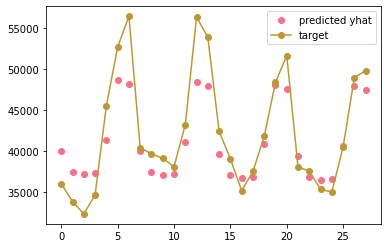

In [52]:
plt.plot(forecast.iloc[-28::].yhat.values, 'o', label="predicted yhat")
plt.plot(eval_df.y.values, 'o-', label="target")
plt.legend();

In [53]:
fig = plot_plotly(m, forecast)  
py.iplot(fig)

## Submission for validation

Remember that we are asked to predict the following intervals PI:

* 99% PI - $u_{1} = 0.005$ and $u_{9} = 0.995$
* 95% PI - $u_{2} = 0.025$ and $u_{8} = 0.975$
* 67% PI - $u_{3} = 0.165$ and $u_{7} = 0.835$
* 50% PI - $u_{4} = 0.25$ and $u_{6} = 0.75$
* median - $u_{5} = 0.5$

Now let's fit the whole training data and predict for the validation timeperiod of the submission file. We have to set the requested intervals in advance.

In [54]:
f_cols = [col for col in submission.columns if "F" in col]

In [55]:
submission_val = submission[submission.id.str.contains("validation")].copy()
submission_eva = submission[submission.id.str.contains("evaluation")].copy()

In [56]:
def plugin_total_predictions(input_value):
    
    for uncertainty_interval_width in [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]:
        upper = 1-uncertainty_interval_width
        lower = uncertainty_interval_width
    
        m = Prophet(interval_width=uncertainty_interval_width)
        m.fit(df)
        future = m.make_future_dataframe(periods=28)
        forecast = m.predict(future)
    
        input_value.loc[
            (input_value.id.str.contains("Total")) & (input_value.id.str.contains(str(lower))),f_cols
        ] = np.round(forecast.yhat_lower.values[-28::])
    
        input_value.loc[
            (input_value.id.str.contains("Total")) & (input_value.id.str.contains(str(upper))),f_cols
        ] = np.round(forecast.yhat_upper.values[-28::])
    
    input_value.loc[
        (input_value.id.str.contains("Total")) & (input_value.id.str.contains(str(0.5))),f_cols
    ] = forecast.yhat.values[-28::]
    
    return input_value

In [57]:
submission_val = plugin_total_predictions(submission_val)
submission_val.loc[submission_val.id.str.contains("Total")]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


id            F1            F2            F3  \
0       Total_X_0.005_validation  39461.680847  36926.937247  36519.877357   
42840   Total_X_0.025_validation  39461.680847  36926.937247  36519.877357   
85680   Total_X_0.165_validation  38692.000000  36205.000000  35568.000000   
128520  Total_X_0.250_validation  43153.000000  40839.000000  40560.000000   
171360  Total_X_0.500_validation  39461.680847  36926.937247  36519.877357   
214200  Total_X_0.750_validation  35528.000000  32850.000000  32671.000000   
257040  Total_X_0.835_validation  34908.000000  32495.000000  32055.000000   
299880  Total_X_0.975_validation  31336.000000  29327.000000  29112.000000   
342720  Total_X_0.995_validation  30677.000000  27981.000000  28198.000000   

                  F4            F5            F6            F7            F8  \
0       36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
42840   36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
85680   35728.000000  39887.000000  47353.000000  46703.000000  38584.000000   
128520  40529.000000  44911.000000  51657.000000  51216.000000  43073.000000   
171360  36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
214200  33106.000000  36459.000000  44111.000000  43762.000000  35026.000000   
257040  31988.000000  35817.000000  43125.000000  42998.000000  34358.000000   
299880  28467.000000  33698.000000  40447.000000  40429.000000  31537.000000   
342720  28373.000000  30924.000000  38517.000000  39167.000000  30234.000000   

                  F9           F10           F11           F12           F13  \
0       36699.986814  36308.987682  36474.819311  40470.074813  47809.854385   
42840   36699.986814  36308.987682  36474.819311  40470.074813  47809.854385   
85680   35877.000000  35712.000000  35765.000000  39803.000000  47000.000000   
128520  40516.000000  40163.000000  40354.000000  44244.000000  51660.000000   
171360  36699.986814  36308.987682  36474.819311  40470.074813  47809.854385   
214200  32899.000000  32157.000000  32333.000000  36699.000000  43616.000000   
257040  31866.000000  31784.000000  31611.000000  35646.000000  42925.000000   
299880  28111.000000  29164.000000  28988.000000  33172.000000  40399.000000   
342720  27670.000000  28040.000000  27640.000000  29958.000000  39485.000000   

                F14           F15           F16           F17           F18  \
0       47375.24831  39109.512183  36617.846926  36257.698756  36458.021235   
42840   47375.24831  39109.512183  36617.846926  36257.698756  36458.021235   
85680   46456.00000  38576.000000  35911.000000  35591.000000  35688.000000   
128520  50935.00000  43201.000000  40766.000000  40276.000000  40543.000000   
171360  47375.24831  39109.512183  36617.846926  36257.698756  36458.021235   
214200  43385.00000  34869.000000  32632.000000  32320.000000  32635.000000   
257040  42585.00000  34029.000000  31949.000000  31377.000000  31332.000000   
299880  40304.00000  31692.000000  29307.000000  27783.000000  28725.000000   
342720  37946.00000  30040.000000  26906.000000  27440.000000  26875.000000   

                 F19          F20          F21           F22           F23  \
0       40491.601394  47873.62449  47485.14468  39269.251834  36830.847436   
42840   40491.601394  47873.62449  47485.14468  39269.251834  36830.847436   
85680   39719.000000  47451.00000  46930.00000  38777.000000  36056.000000   
128520  44541.000000  52174.00000  51581.00000  42943.000000  40954.000000   
171360  40491.601394  47873.62449  47485.14468  39269.251834  36830.847436   
214200  36608.000000  43834.00000  43593.00000  35477.000000  33014.000000   
257040  35767.000000  43009.00000  42802.00000  34676.000000  31954.000000   
299880  33065.000000  40027.00000  39696.00000  31409.000000  29668.000000   
342720  30205.000000  38952.00000  37441.00000  30195.000000  27228.000000   

                 F24           F25           F26           F27           F2

In [58]:
submission_eva = plugin_total_predictions(submission_eva)
submission_eva.loc[submission_eva.id.str.contains("Total")]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


id            F1            F2            F3  \
385560  Total_X_0.005_evaluation  39461.680847  36926.937247  36519.877357   
428400  Total_X_0.025_evaluation  39461.680847  36926.937247  36519.877357   
471240  Total_X_0.165_evaluation  38673.000000  36373.000000  35945.000000   
514080  Total_X_0.250_evaluation  43377.000000  40947.000000  40649.000000   
556920  Total_X_0.500_evaluation  39461.680847  36926.937247  36519.877357   
599760  Total_X_0.750_evaluation  35403.000000  32731.000000  32237.000000   
642600  Total_X_0.835_evaluation  34786.000000  32124.000000  31966.000000   
685440  Total_X_0.975_evaluation  31777.000000  29160.000000  29226.000000   
728280  Total_X_0.995_evaluation  30368.000000  26992.000000  26590.000000   

                  F4            F5            F6            F7            F8  \
385560  36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
428400  36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
471240  35957.000000  39907.000000  47156.000000  46786.000000  38543.000000   
514080  40795.000000  44465.000000  51859.000000  51273.000000  43028.000000   
556920  36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
599760  32415.000000  36686.000000  44116.000000  43544.000000  35277.000000   
642600  31585.000000  36082.000000  43343.000000  42743.000000  34217.000000   
685440  28960.000000  32604.000000  40313.000000  40261.000000  31511.000000   
728280  27484.000000  31322.000000  38742.000000  38067.000000  29915.000000   

                  F9           F10           F11           F12           F13  \
385560  36699.986814  36308.987682  36474.819311  40470.074813  47809.854385   
428400  36699.986814  36308.987682  36474.819311  40470.074813  47809.854385   
471240  35925.000000  35392.000000  35884.000000  39780.000000  47133.000000   
514080  40777.000000  40102.000000  40651.000000  44553.000000  51724.000000   
556920  36699.986814  36308.987682  36474.819311  40470.074813  47809.854385   
599760  32724.000000  32191.000000  32651.000000  36664.000000  44172.000000   
642600  32073.000000  31613.000000  31856.000000  35691.000000  43119.000000   
685440  29427.000000  29066.000000  28801.000000  33201.000000  40190.000000   
728280  27824.000000  27189.000000  27024.000000  30701.000000  38978.000000   

                F14           F15           F16           F17           F18  \
385560  47375.24831  39109.512183  36617.846926  36257.698756  36458.021235   
428400  47375.24831  39109.512183  36617.846926  36257.698756  36458.021235   
471240  46701.00000  38562.000000  36026.000000  35428.000000  35772.000000   
514080  51314.00000  43308.000000  40486.000000  40166.000000  40093.000000   
556920  47375.24831  39109.512183  36617.846926  36257.698756  36458.021235   
599760  43570.00000  35208.000000  32416.000000  32379.000000  32215.000000   
642600  42960.00000  34530.000000  31626.000000  31447.000000  32074.000000   
685440  39773.00000  31758.000000  29643.000000  28512.000000  28079.000000   
728280  38274.00000  29923.000000  26914.000000  26493.000000  26701.000000   

                 F19          F20          F21           F22           F23  \
385560  40491.601394  47873.62449  47485.14468  39269.251834  36830.847436   
428400  40491.601394  47873.62449  47485.14468  39269.251834  36830.847436   
471240  39842.000000  47142.00000  46687.00000  38604.000000  36295.000000   
514080  44417.000000  51936.00000  51387.00000  43220.000000  40824.000000   
556920  40491.601394  47873.62449  47485.14468  39269.251834  36830.847436   
599760  36581.000000  43905.00000  43852.00000  35117.000000  32819.000000   
642600  35457.000000  42997.00000  42758.00000  34846.000000  32106.000000   
685440  32388.000000  40961.00000  39722.00000  31745.000000  29277.000000   
728280  30752.000000  39371.00000  37974.00000  30452.000000  26769.000000   

                 F24           F25           F26           F27           F2

In [60]:
submission = pd.concat([submission_val, submission_eva])
#submission.set_index('id', inplace=True)
submission.to_csv('submission.csv', index=None, float_format='%.5g')
submission

id            F1            F2  \
0                Total_X_0.005_validation  39461.680847  36926.937247   
1                   CA_X_0.005_validation      0.000000      0.000000   
2                   TX_X_0.005_validation      0.000000      0.000000   
3                   WI_X_0.005_validation      0.000000      0.000000   
4                 CA_1_X_0.005_validation      0.000000      0.000000   
...                                   ...           ...           ...   
771115  FOODS_3_823_WI_3_0.995_evaluation      0.000000      0.000000   
771116  FOODS_3_824_WI_3_0.995_evaluation      0.000000      0.000000   
771117  FOODS_3_825_WI_3_0.995_evaluation      0.000000      0.000000   
771118  FOODS_3_826_WI_3_0.995_evaluation      0.000000      0.000000   
771119  FOODS_3_827_WI_3_0.995_evaluation      0.000000      0.000000   

                  F3            F4            F5            F6            F7  \
0       36519.877357  36668.818651  40645.949363  47965.928954  47509.392806   
1           0.000000      0.000000      0.000000      0.000000      0.000000   
2           0.000000      0.000000      0.000000      0.000000      0.000000   
3           0.000000      0.000000      0.000000      0.000000      0.000000   
4           0.000000      0.000000      0.000000      0.000000      0.000000   
...              ...           ...           ...           ...           ...   
771115      0.000000      0.000000      0.000000      0.000000      0.000000   
771116      0.000000      0.000000      0.000000      0.000000      0.000000   
771117      0.000000      0.000000      0.000000      0.000000      0.000000   
771118      0.000000      0.000000      0.000000      0.000000      0.000000   
771119      0.000000      0.000000      0.000000      0.000000      0.000000   

                  F8            F9           F10           F11           F12  \
0       39219.150125  36699.986814  36308.987682  36474.819311  40470.074813   
1           0.000000      0.000000      0.000000      0.000000      0.000000   
2           0.000000      0.000000      0.000000      0.000000      0.000000   
3           0.000000      0.000000      0.000000      0.000000      0.000000   
4           0.000000      0.000000      0.000000      0.000000      0.000000   
...              ...           ...           ...           ...           ...   
771115      0.000000      0.000000      0.000000      0.000000      0.000000   
771116      0.000000      0.000000      0.000000      0.000000      0.000000   
771117      0.000000      0.000000      0.000000      0.000000      0.000000   
771118      0.000000      0.000000      0.000000      0.000000      0.000000   
771119      0.000000      0.000000      0.000000      0.000000      0.000000   

                 F13          F14           F15           F16           F17  \
0       47809.854385  47375.24831  39109.512183  36617.846926  36257.698756   
1           0.000000      0.00000      0.000000      0.000000      0.000000   
2           0.000000      0.00000      0.000000      0.000000      0.000000   
3           0.000000      0.00000      0.000000      0.000000      0.000000   
4           0.000000      0.00000      0.000000      0.000000      0.000000   
...              ...          ...           ...           ...           ...   
771115      0.000000      0.00000      0.000000      0.000000      0.000000   
771116      0.000000      0.00000      0.000000      0.000000      0.000000   
771117      0.000000      0.00000      0.000000      0.000000      0.000000   
771118      0.000000      0.00000      0.000000      0.000000      0.000000   
771119      0.000000      0.00000      0.000000      0.000000      0.000000   

                 F18           F19          F20          F21           F22  \
0       36458.021235  40491.601394  47873.62449  47485.14468  39269.251834   
1           0.000000      0.000000      0.00000      0.00000      0.000000   
2           0.000000      0.000000      0.00000      0.00

I'm not sure if this whole stuff makes sense. Personally I feel a strong need for Bayesian ML and [credible intervals](https://en.wikipedia.org/wiki/Credible_interval). What I miss most is a much more detailed mathematical description of Prophet in the documentation so I can know how to improve the accuracy score. Only using the model without a deeper understanding of what is going on feels very sloppy and dangerous. :-(

This concludes this notebook on this amazing dataset. Many thanks to all of you for reading this kernel, please do provide your feedback in the shapes of upvotes and comments. 

I’ll be glad if you find my work useful, and I’m always open to questions and constructive criticism. I thoroughly appreciate your support! 